# Lab 0: PyTorch Tutorial

In this tutorial, we will explore how to train a neural network with PyTorch.

### Setup

We will first install a few packages that will be used in this tutorial:

In [ ]:
!pip install torchprofile 1>/dev/null

We will then import a few libraries:

In [ ]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

To ensure the reproducibility, we will control the seed of random generators:

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Data

In this tutorial, we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [ ]:
transforms = {
  "train": Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
  ]),
  "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


We can visualize a few images in the dataset and their corresponding class labels:

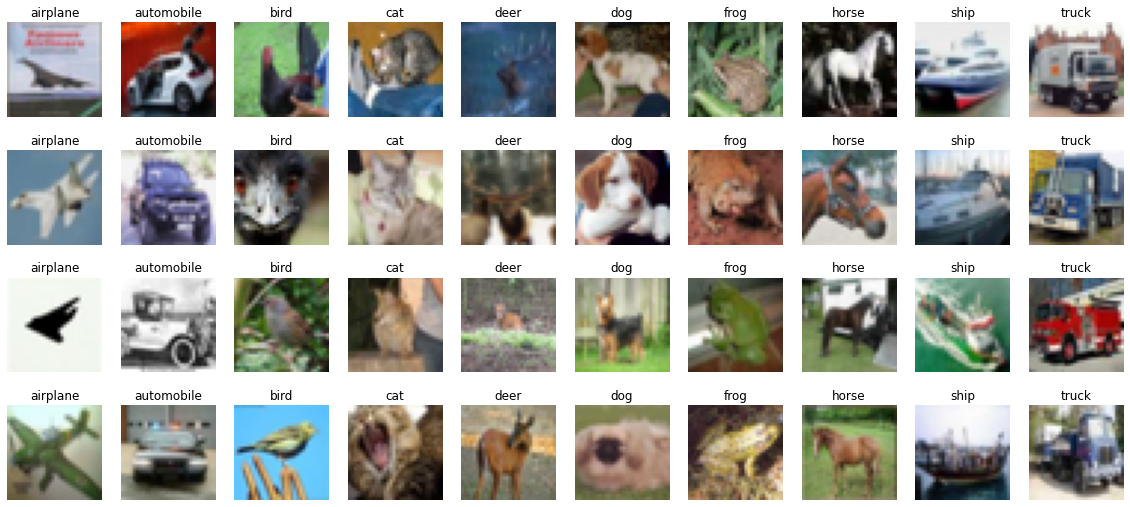

In [ ]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

To train a neural network, we will need to feed data in batches. We create data loaders with batch size of 512:

In [ ]:
dataflow = {}
for split in ['train', 'test']:
  dataflow[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

We can print the data type and shape from the training data loader:

In [ ]:
for inputs, targets in dataflow["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


### Model

In this tutorial, we will use a variant of [VGG-11](https://arxiv.org/abs/1409.1556) (with fewer downsamples and a smaller classifier) as our model.

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x
  
model = VGG().cuda()

Its backbone is composed of eight `conv-bn-relu` blocks interleaved with four `maxpool`'s to downsample the feature map by 2^4 = 16 times:

In [ ]:
print(model.backbone)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

After the feature map is pooled, its classifier predicts the final output with a linear layer:

In [ ]:
print(model.classifier)

Linear(in_features=512, out_features=10, bias=True)


As this course focuses on efficiency, we will then inspect its model size and (theoretical) computation cost.


* The model size can be estimated by the number of trainable parameters:

In [ ]:
num_params = 0
for param in model.parameters():
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 9228362


* The computation cost can be estimated by the number of [multiply–accumulate operations (MACs)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) using [TorchProfile](https://github.com/zhijian-liu/torchprofile):

In [ ]:
num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32).cuda())
print("#MACs:", num_macs)

#MACs: 606164480


This model has 9.2M parameters and requires 606M MACs for inference. We will work together in the next few labs to improve its efficiency.

### Optimization

As we are working on a classification problem, we will apply [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function to optimize the model:

In [ ]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum):

In [ ]:
optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

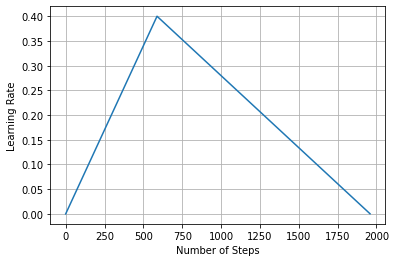

In [ ]:
num_epochs = 20
steps_per_epoch = len(dataflow["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],
  [0, 1, 0]
)[0]

# Visualize the learning rate schedule
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

### Training

We first define the training function that optimizes the model for one epoch (*i.e.*, a pass over the training set):

In [ ]:
def train(
  model: nn.Module,
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataflow, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

We then define the evaluation function that calculates the metric (*i.e.*, accuracy in our case) on the test set:

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

With training and evaluation functions, we can finally start training the model! This will take around 10 minutes.

In [ ]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataflow["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataflow["test"])
  print(f"epoch {epoch_num}:", metric)

  0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1: 21.419998168945312


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 2: 67.42999267578125


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 3: 59.16999435424805


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 4: 66.62999725341797


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 5: 61.269996643066406


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 6: 50.61000061035156


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 7: 73.7699966430664


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 8: 65.12000274658203


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 9: 70.41999816894531


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 10: 73.39999389648438


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 11: 70.55999755859375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 12: 75.31999969482422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 13: 82.81999969482422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 14: 85.99999237060547


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 15: 79.35999298095703


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 16: 84.87999725341797


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 17: 87.08999633789062


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 18: 91.37999725341797


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 19: 92.50999450683594


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 20: 93.13999938964844


If everything goes well, your trained model should be able to achieve >92.5\% of accuracy!

### Visualization

We can visualize the model's prediction to see how the model truly performs:

In [ ]:
plt.figure(figsize=(20, 10))
for index in range(40):
  image, label = dataset["test"][index]

  # Model inference
  model.eval()
  with torch.inference_mode():
    pred = model(image.unsqueeze(dim=0).cuda())
    pred = pred.argmax(dim=1)

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class indices to class names
  pred = dataset["test"].classes[pred]
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(f"pred: {pred}" + "\n" + f"label: {label}")
  plt.axis("off")
plt.show()

NameError: ignored